#**Get the Image Data Set From Github and create a Folder**

In [1]:
!git clone https://github.com/Hrushi11/Real-TIme-Skin-Type-Detection.git

Cloning into 'Real-TIme-Skin-Type-Detection'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 548 (delta 0), reused 3 (delta 0), pack-reused 545
Receiving objects: 100% (548/548), 234.11 MiB | 37.99 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (541/541), done.


In [2]:
import os
import shutil
src_dir ='/content/Real-TIme-Skin-Type-Detection/skin-dataset/oily'
datafile = '/content/datafile' #create a folder to move images in repository
files = os.listdir(src_dir)
shutil.copytree(src_dir, datafile)

'/content/datafile'

In [3]:
oil_dir_path = '/content/datafile'
oily_items = items = os.listdir(oil_dir_path)
print(len(oily_items))

143


In [4]:
#since if there are 4 types of oiliness need to be predicted. There must be 35 images along with one category
#35 random dry images will asign to the data file folder
import os
import shutil
import random

source_directory = "/content/Real-TIme-Skin-Type-Detection/skin-dataset/dry"
destination_directory = "/content/datafile"
num_images_to_copy = 35

# Get the list of all files in the source directory
all_files = os.listdir(source_directory)

# Randomly select 35 files
random_files = random.sample(all_files, num_images_to_copy)

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Copy selected files to the destination directory
for file_name in random_files:
    source_path = os.path.join(source_directory, file_name)
    destination_path = os.path.join(destination_directory, file_name)
    shutil.copy(source_path, destination_path)

print(f"{num_images_to_copy} random images have been copied to {destination_directory}.")


35 random images have been copied to /content/datafile.


#**Image Augmentation and Saving Images in a Separate Folders**

In [5]:
import os
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Set the paths for the original and augmented images
original_folder = "/content/datafile"
augmented_folder = "/content/augmented_folder"

# Create the augmented folder if it doesn't exist
os.makedirs(augmented_folder, exist_ok=True)

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to apply sharpening filter
def sharpen_image(image):
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

# Iterate through all images
for img_name in os.listdir(original_folder):
    img_path = os.path.join(original_folder, img_name)

    # Check if the file is an image
    if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(img_path)

        # Check if the image was successfully loaded
        if img is not None:
            # Apply sharpening filter
            sharpened_img = sharpen_image(img)

            # Save the sharpened image
            sharpened_path = os.path.join(augmented_folder, f"{img_name.split('.')[0]}_sharpened.jpg")
            cv2.imwrite(sharpened_path, sharpened_img)

            # Augment and save images
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

            for i, batch in enumerate(datagen.flow(img, batch_size=1, save_to_dir=augmented_folder, save_prefix='aug', save_format='jpeg')):
                if i >= 4:  # adjust the number of augmentations as needed
                    break



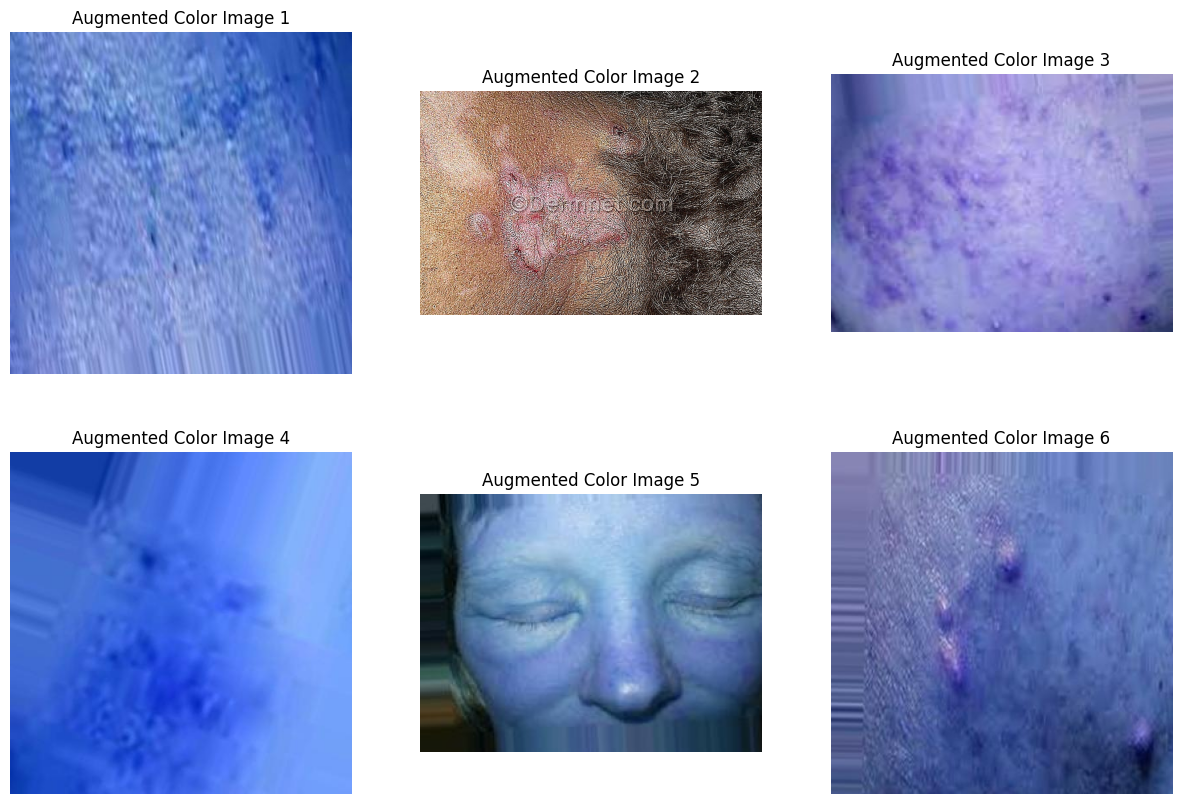

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

# Set the paths for the augmented color images
augmented_folder = "/content/augmented_folder"

# Display augmented color images
plt.figure(figsize=(15, 10))

for i, img_name in enumerate(os.listdir(augmented_folder)[:6]):  # Displaying the first 6 images
    img_path = os.path.join(augmented_folder, img_name)

    # Read and display the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for displaying with matplotlib
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Augmented Color Image {i + 1}')
    plt.axis('off')

plt.show()




#**K Mean Clustering for Augmented Images**

In [7]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Read and preprocess augmented images
augmented_images = []
for img_name in os.listdir(augmented_folder):
    img_path = os.path.join(augmented_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize all images to a common size
    augmented_images.append(img.flatten())

# Convert list to NumPy array
augmented_images = np.array(augmented_images)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(augmented_images)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


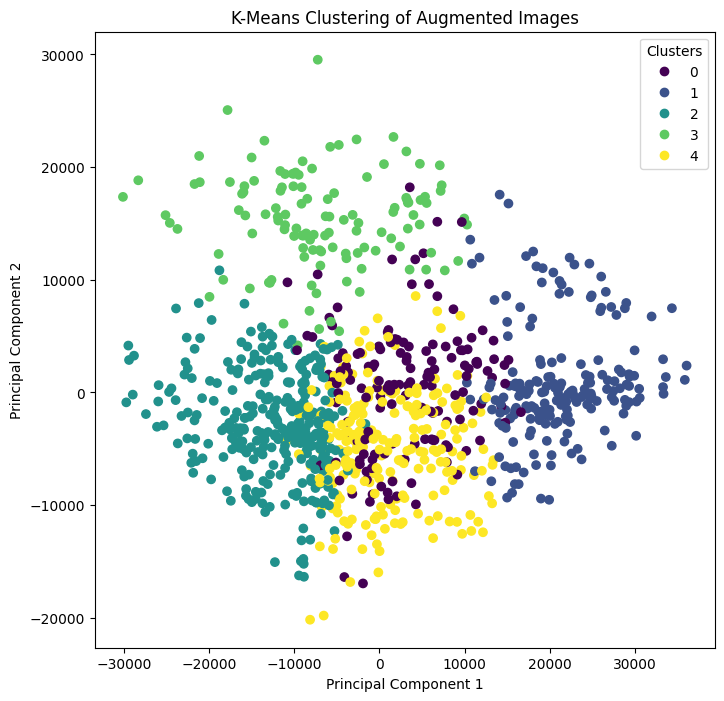

In [8]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
augmented_images_pca = pca.fit_transform(augmented_images)

# Plot the clusters
plt.figure(figsize=(8, 8))
scatter = plt.scatter(augmented_images_pca[:, 0], augmented_images_pca[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering of Augmented Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()


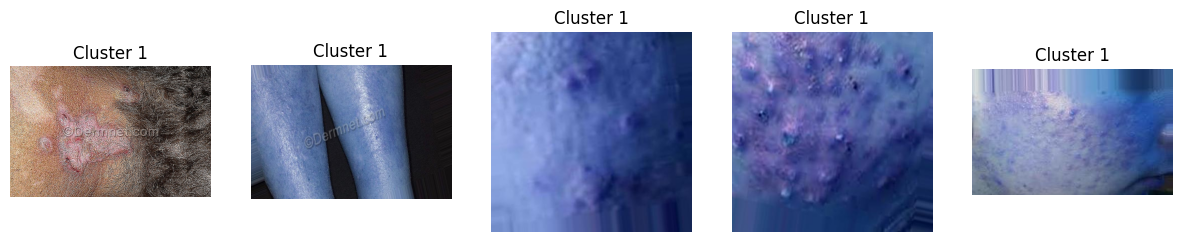

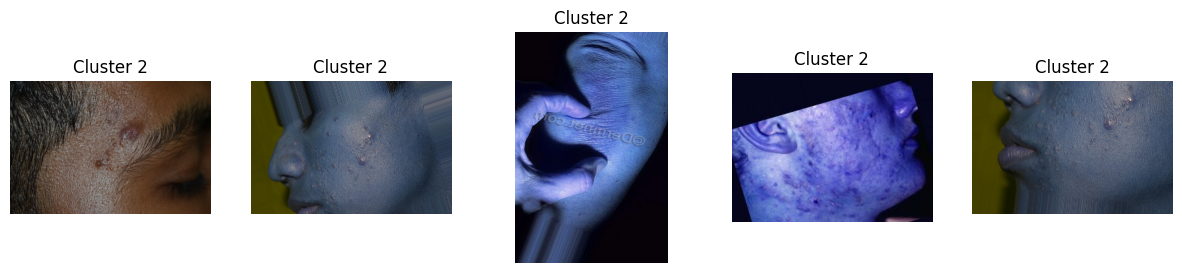

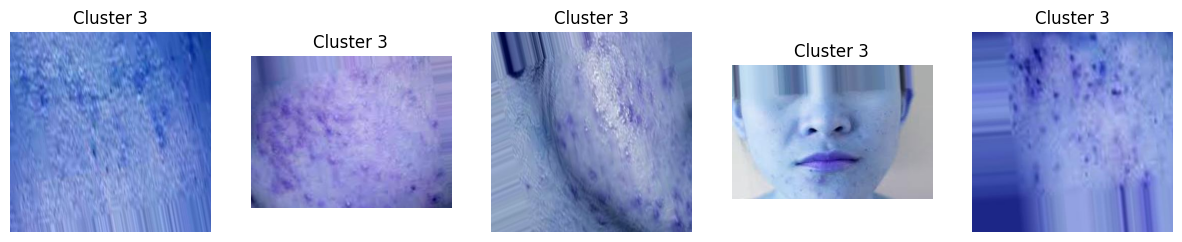

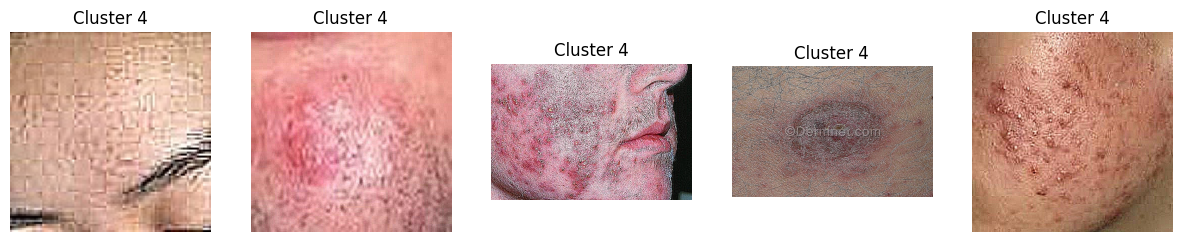

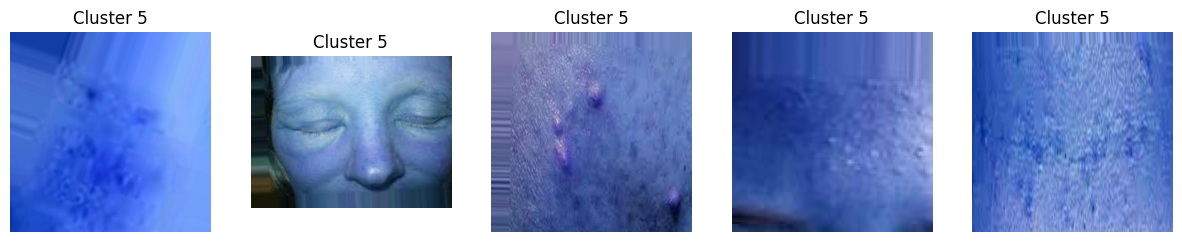

In [9]:
# Visualize the results
for cluster_num in range(5):
    cluster_indices = np.where(clusters == cluster_num)[0]
    plt.figure(figsize=(15, 3))

    for i, img_index in enumerate(cluster_indices[:5]):  # Displaying up to 5 images from each cluster
        img_path = os.path.join(augmented_folder, os.listdir(augmented_folder)[img_index])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Cluster {cluster_num + 1}')
        plt.axis('off')

    plt.show()

In [10]:
# Print the category number and number of images in each category
for category_num in range(5):
    category_indices = np.where(clusters == category_num)[0]
    print(f"Oiliness Category {category_num + 1}: {len(category_indices)} images")

Oiliness Category 1: 152 images
Oiliness Category 2: 195 images
Oiliness Category 3: 317 images
Oiliness Category 4: 121 images
Oiliness Category 5: 226 images


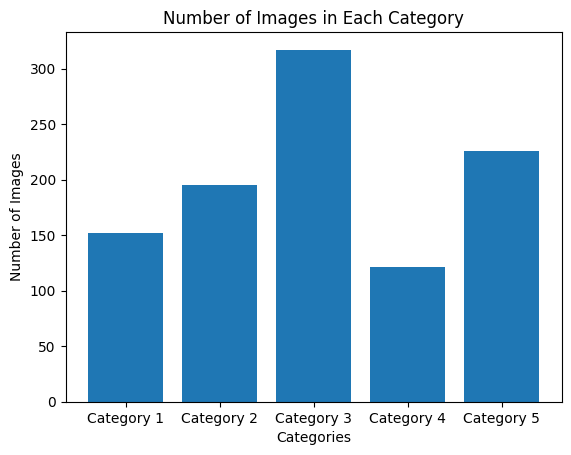

In [11]:
# Count the number of images in each category
category_counts = [np.sum(clusters == category_num) for category_num in range(5)]

# Plot the bar chart
categories = ["Category 1", "Category 2", "Category 3", "Category 4",'Category 5']
plt.bar(categories, category_counts)
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.show()

# **Categorization and Saving**

In [ ]:
import os

categorized_folder = "/content/categorized_folder"

# Create folders for each category
for i in range(4):
    os.makedirs(os.path.join(categorized_folder, f"category_{i+1}"), exist_ok=True)

# Move images to their respective categories
for i, img_name in enumerate(os.listdir(augmented_folder)):
    img_path = os.path.join(augmented_folder, img_name)

    # Add debug print statements
    print(f"Processing {img_name}, index {i}, clusters length {len(clusters)}")

    category = clusters[i] + 1  # clusters are 0-indexed, so adding 1 to start from category_1
    category_folder = os.path.join(categorized_folder, f"category_{category}")

    # Add another debug print statement
    print(f"Moving {img_name} to {category_folder}")

    try:
        os.rename(img_path, os.path.join(category_folder, img_name))
    except FileNotFoundError as e:
        print(f"Error moving {img_name}: {e}")


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Move images to their respective categories
for i, img_name in enumerate(os.listdir(augmented_folder)):
    img_path = os.path.join(augmented_folder, img_name)

    # Check if the file exists before attempting to move it
    if os.path.isfile(img_path):
        category = clusters[i] + 1  # clusters are 0-indexed, so adding 1 to start from category_1
        category_folder = os.path.join(categorized_folder, f"category_{category}")

        # Ensure the destination folder exists
        os.makedirs(category_folder, exist_ok=True)

        try:
            os.rename(img_path, os.path.join(category_folder, img_name))
        except FileNotFoundError as e:
            print(f"Error moving {img_name}: {e}")
    else:
        print(f"File {img_name} not found.")


# **Splitting the Data to Training**

In [14]:
from sklearn.model_selection import train_test_split

train_folder = "/content/training"
valid_folder = "/content/validation"

# Iterate through each category and split data
for i in range(1, 6):
    category_folder = os.path.join(categorized_folder, f"category_{i}")
    images = os.listdir(category_folder)

    # Check if there are images in the category folder
    if len(images) > 0:
        train_images, valid_images = train_test_split(images, test_size=0.2, random_state=42)

        # Move images to training folder
        for img_name in train_images:
            src_path = os.path.join(category_folder, img_name)
            dest_path = os.path.join(train_folder, f"category_{i}", img_name)
            os.makedirs(os.path.join(train_folder, f"category_{i}"), exist_ok=True)
            os.rename(src_path, dest_path)

        # Move images to validation folder
        for img_name in valid_images:
            src_path = os.path.join(category_folder, img_name)
            dest_path = os.path.join(valid_folder, f"category_{i}", img_name)
            os.makedirs(os.path.join(valid_folder, f"category_{i}"), exist_ok=True)
            os.rename(src_path, dest_path)
    else:
        print(f"No images found in {category_folder}. Skipping split.")


#**CNN Model**

In [15]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
import matplotlib.pyplot as plt

# Set the paths for training and validation data
train_folder = "/content/training"
valid_folder = "/content/validation"

# Set image dimensions
img_width, img_height = 224, 224

# Set batch size
train_batch_size = 16
valid_batch_size = 8

#**Model Training**

Found 808 images belonging to 5 classes.
Found 203 images belonging to 5 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/30
50/50 [==============================] - 20s 224ms/step - loss: 12.5822 - accuracy: 0.5114 - val_loss: 10.9783 - val_accuracy: 0.4700
Epoch 2/30
50/50 [==============================] - 8s 158ms/step - loss: 9.4227 - accuracy: 0.8043 - val_loss: 9.0385 - val_accuracy: 0.6400
Epoch 3/30
50/50 [==============================] - 9s 169ms/step - loss: 7.9582 - accuracy: 0.8775 - val_loss: 7.9934 - val_accuracy: 0.6800
Epoch 4/30
50/50 [==============================] - 9s 174ms/step - loss: 7.0628 - accuracy: 0.9192 - val_loss: 7.3389 - val_accuracy: 0.6750
Epoch 5/30
50/50 [==============================] - 9s 178ms/step - loss: 6.3891 - accuracy: 0.9545 - val_loss: 6.8219 - val_accuracy: 0.6600
Epoch 6/30
50/50 [==============================] - 8s 162ms/step - loss: 5.8238 - accuracy: 0.9785 - val_loss: 6.3556 - val_accuracy: 0.650

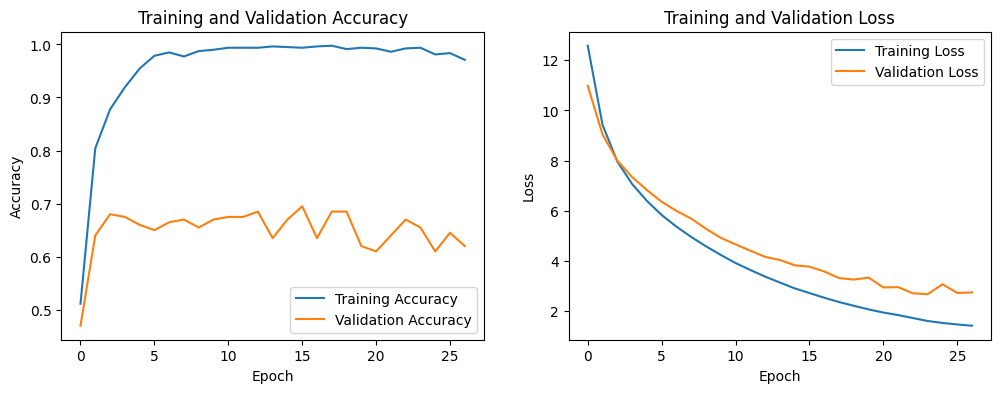

26/26 [==============================] - 3s 135ms/step - loss: 2.7245 - accuracy: 0.6207
Validation Loss: 2.7245
Validation Accuracy: 62.07%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:


# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=train_batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_folder,
    target_size=(img_width, img_height),
    batch_size=valid_batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.05))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(5, activation='softmax'))

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with early stopping
epochs = 30
try:
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_batch_size,
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=valid_generator.samples // valid_batch_size,
        callbacks=[early_stopping]
    )
except Exception as e:
    print(f"Error during training: {e}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(valid_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model.save("/content/saved_model.h5")



# **Colab Face Detetction code using web cam**

Imports

In [17]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

starting web cam

In [18]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

press cature to take a photo

In [19]:
image_file = take_photo()

<IPython.core.display.Javascript object>

resize the image

400 300


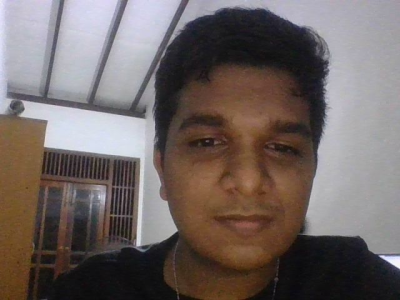

In [20]:
#image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image = cv2.imread(image_file)

# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w,h)
cv2_imshow(image)

Download the pre-trained face detection model, consisting of two files:

- The network definition (deploy.prototxt)
- The learned weights (res10_300x300_ssd_iter_140000.caffemodel)

In [21]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2024-02-20 19:18:16--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2024-02-20 19:18:16 (17.5 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2024-02-20 19:18:16--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [22]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model_capture = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model_capture)

[INFO] loading model...


In [23]:
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [24]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


In [25]:
for i in range(0, detections.shape[2]):

	# extract the confidence (i.e., probability) associated with the prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the `confidence` is
	# greater than the minimum confidence threshold
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# draw the bounding box of the face along with the associated probability
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]

    if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # Crop the region of interest (ROI)
        roi = image[startY:endY, startX:endX]

        # Save the cropped image
        cv2.imwrite(f"cropped_face_{i}.jpg", roi)

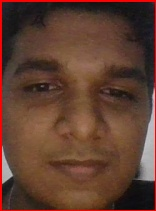

In [26]:
from IPython.display import Image, display

# Specify the path to the saved image
image_path = "/content/cropped_face_0.jpg"

# Display the image
display(Image(filename=image_path))


# **Skin detection Code**

In [27]:
!git clone https://github.com/mpatacchiola/deepgaze.git

Cloning into 'deepgaze'...
remote: Enumerating objects: 1324, done.
remote: Total 1324 (delta 0), reused 0 (delta 0), pack-reused 1324
Receiving objects: 100% (1324/1324), 239.15 MiB | 33.70 MiB/s, done.
Resolving deltas: 100% (733/733), done.
Updating files: 100% (170/170), done.


In [28]:
!pip install /content/deepgaze

Processing ./deepgaze
  Preparing metadata (setup.py) ... done
  Created wheel for deepgaze: filename=deepgaze-0.1-py3-none-any.whl size=40413 sha256=fbc245564d614c895cc8b9de71fdf14471ab3a34dfb1b3b091c421d301dcbbdc
  Stored in directory: /tmp/pip-ephem-wheel-cache-qzlc4agh/wheels/06/cb/99/3f1cfaa91774996b3acd87bf32f415e5e536ed238eb3ededb2
Successfully built deepgaze


In [29]:
import numpy as np
import cv2
from deepgaze.color_detection import RangeColorDetector
from matplotlib import pyplot as plt

In [30]:
min_range = np.array([0, 48, 70], dtype = "uint8") #lower HSV boundary of skin color
max_range = np.array([20, 150, 255], dtype = "uint8") #upper HSV boundary of skin color
my_skin_detector = RangeColorDetector(min_range, max_range) #Define the detector object
image = cv2.imread("/content/cropped_face_0.jpg") #Read the image with OpenCV
#We do not need to remove noise from this image so morph_opening and blur are se to False
image_filtered = my_skin_detector.returnFiltered(image, morph_opening=False, blur=False, kernel_size=3, iterations=1)
cv2.imwrite("testing_image.jpg", image_filtered) #Save the filtered image

True

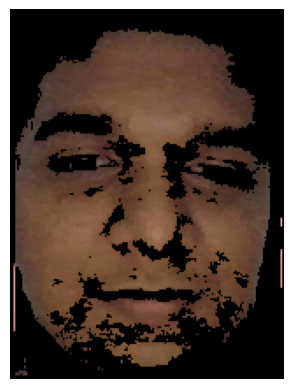

In [31]:
plt.imshow(cv2.cvtColor(image_filtered, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.show()

#**Testing the Image**

preprocess the testing image

In [32]:
import cv2
import numpy as np

test_image_path = "/content/testing_image.jpg"  # Replace with the actual path to your test image
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Ensure the correct color format
test_image = cv2.resize(test_image, (224, 224))  # Resize to match the input size used during training

# Apply grayscale scaling
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
test_image_gray = cv2.cvtColor(test_image_gray, cv2.COLOR_GRAY2RGB)  # Convert back to 3 channels for compatibility

test_image_gray = test_image_gray / 255.0  # Normalize pixel values to the range [0, 1]

# Reshape the image to match the input shape expected by your model
test_image_gray = np.reshape(test_image_gray, (1, 224, 224, 3))



loading the model

In [33]:
from keras.models import load_model

model_path = "/content/saved_model.h5"  # Replace with the actual path to your saved model
model = load_model(model_path)


In [34]:
# Assuming you have already loaded and preprocessed the test image as test_image_gray
# If not, you can use the previously provided code to load and preprocess the image

# Make predictions
predictions = model.predict(test_image_gray)

# Assuming you want to get the predicted class
predicted_class = np.argmax(predictions)


1/1 [==============================] - 1s 1s/step


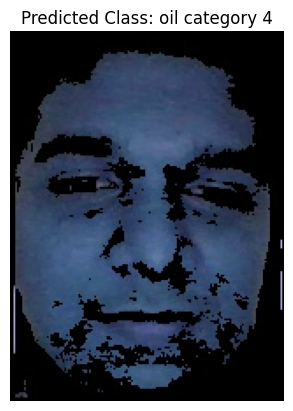

In [35]:
import matplotlib.pyplot as plt

# Assuming you have a list of class labels
class_labels = ["oil category 1", "oil category 2", "oil category 3", "oil category 4","oily catergory 5"]

plt.imshow(cv2.imread(test_image_path))
plt.title(f"Predicted Class: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()
